# Introduction

Hello! My name is Evan Freeman. Let's analyze a timeseries dataset. "Timeseries" means that we are given some piece of information, in this case count of traffic, at a specific date and time. It is our job as a Data Scientist to unpack that date and time into many valuable piece of information and look for patterns to help us predict future behavior.

# Competition Description

Competition: Time Series  

https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/  

About Practice Problem: Time Series  
Time Series forecasting & modeling plays an important role in data analysis. Time series analysis is a specialized branch of statistics used extensively in fields such as Econometrics & Operation Research.  

Time Series is being widely used in analytics & data science. This is specifically designed time series problem for you and challenge is to forecast traffic.  

Rules:  
1. One person cannot participate with more than one user accounts.
2. This is proprietary dataset, you can only use for this hackathon (Analytics Vidhya Datahack Platform) not for any other reuse
3. You are free to use any tool and machine you have rightful access to.
4. You can use any programming language or statistical software.
5. You are free to use solution checker as many times as you want.

Welcome DataHacker!
 
Congratulations on your new job! This time you are helping out Unicorn Investors with your data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

Evaluation Metric:

Root Mean Squre Error (RMSE) is the evaluation metric for this contest

Note: Public and private split is 20:80 where first 44 days in public and next 169 days in private

# Setup

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.model_selection import RandomizedSearchCV as rscv
import warnings
from itertools import permutations

warnings.filterwarnings('ignore')

# pd.options.display.max_columns = None
# pd.options.display.max_rows = 56

filepath = 'D:/code/Data/time_series_datahack/'

data = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')
sample = pd.read_csv(f'{filepath}sample_submission.csv')

# Data Exploration

In [2]:
display(data)
display(test)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00
...,...,...
5107,23395,26-04-2015 19:00
5108,23396,26-04-2015 20:00
5109,23397,26-04-2015 21:00
5110,23398,26-04-2015 22:00


Oh. There's only 1 input and 1 output.  

Well, that may not seem like a lot, but think of all the FEATURE GENERATION you can do!!!
1. Year, Month, Day, Hour
2. Traffic in a preceding window of time (like traffic in the past x minutes)
3. Holidays!
4. More!!!

Make sure to train the FINAL model on ALL the data, after all parameters have been selected!!!

In [3]:
data.describe()

#Why the crap doesn't it describe the Datetime? Maybe because they're all unique.

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


# Data Cleaning

In [4]:
display(data.isnull().sum())

ID          0
Datetime    0
Count       0
dtype: int64

Nice! No missing data. Easy Mode!        

We should check if there's any gaps in the dates, or if it's a continuous run.  I'll do that later, probably.


The dates are spread out at hour intervals. Looks like 2 years of data. Dope!!

# Feature Generation

Let's do some feature generation:  
1. Year
2. Month
3. Day
4. Hour
5. Day of the week
6. Day of the year
7. Week of the year

In [5]:
# First, convert from string to the datetime object in Pandas. This makes it easier to find the year, month, etc...
data['Datetime'] = pd.to_datetime(data['Datetime'], format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format = '%d-%m-%Y %H:%M')

# Now, some features

#Here's a function to generate the desired features
def domain_features(df):
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Dayofweek'] = df['Datetime'].dt.dayofweek
    df['Dayofyear'] = df['Datetime'].dt.dayofyear
    df['Week'] = df['Datetime'].dt.week
    
domain_features(data)
domain_features(test)

#Ideally, we will also generate some range features. Things like lag (Count in a previous window of time). But I need to research how to do this for the test data as well
# I guess you'd predict row 1, then generate lag, then predict row 2, then generate more lag, etc.

In [6]:
display(data)

,ID,Datetime,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,238,34
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,238,34
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,238,34
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,238,34
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,238,34
...,...,...,...,...,...,...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19,3,268,39
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20,3,268,39
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21,3,268,39
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22,3,268,39


# Data Plotting

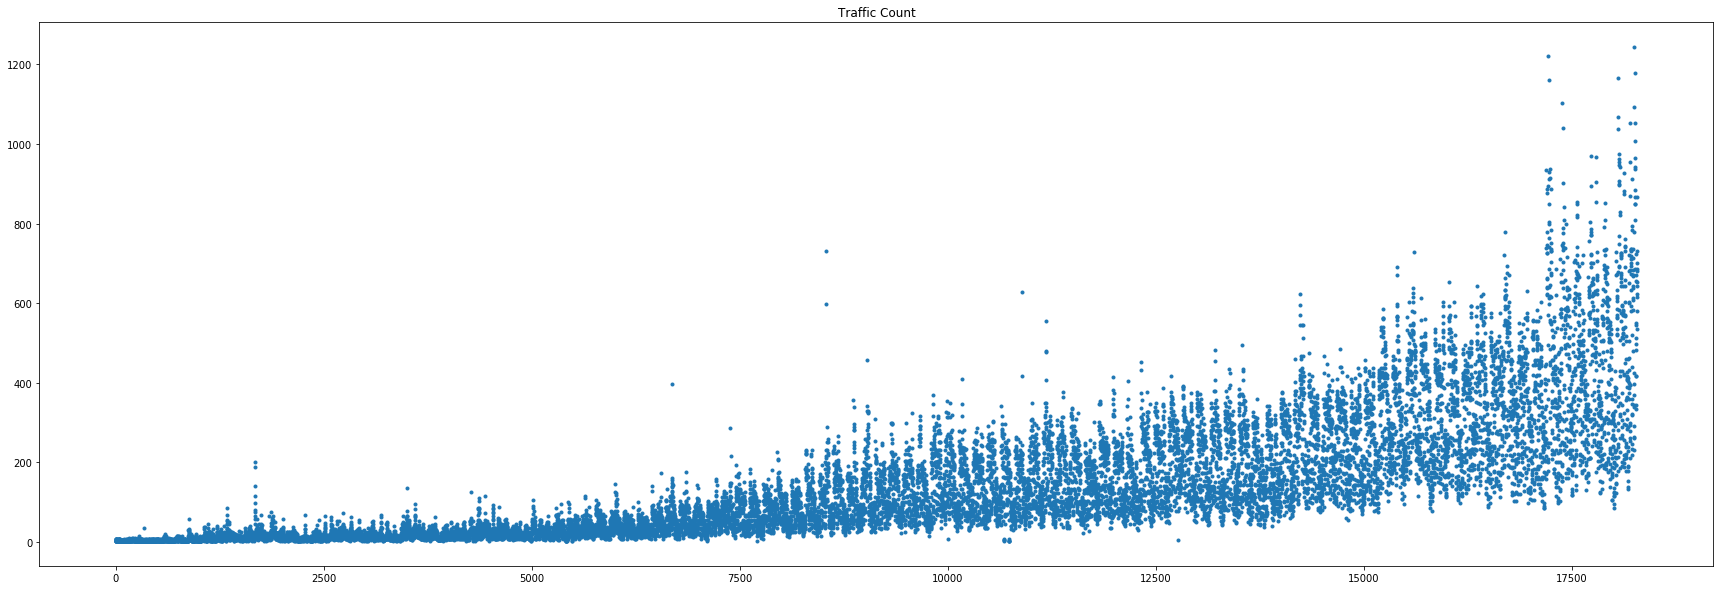

In [7]:
plt.figure(figsize = (30, 10))
data.Count.plot(style = '.')
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

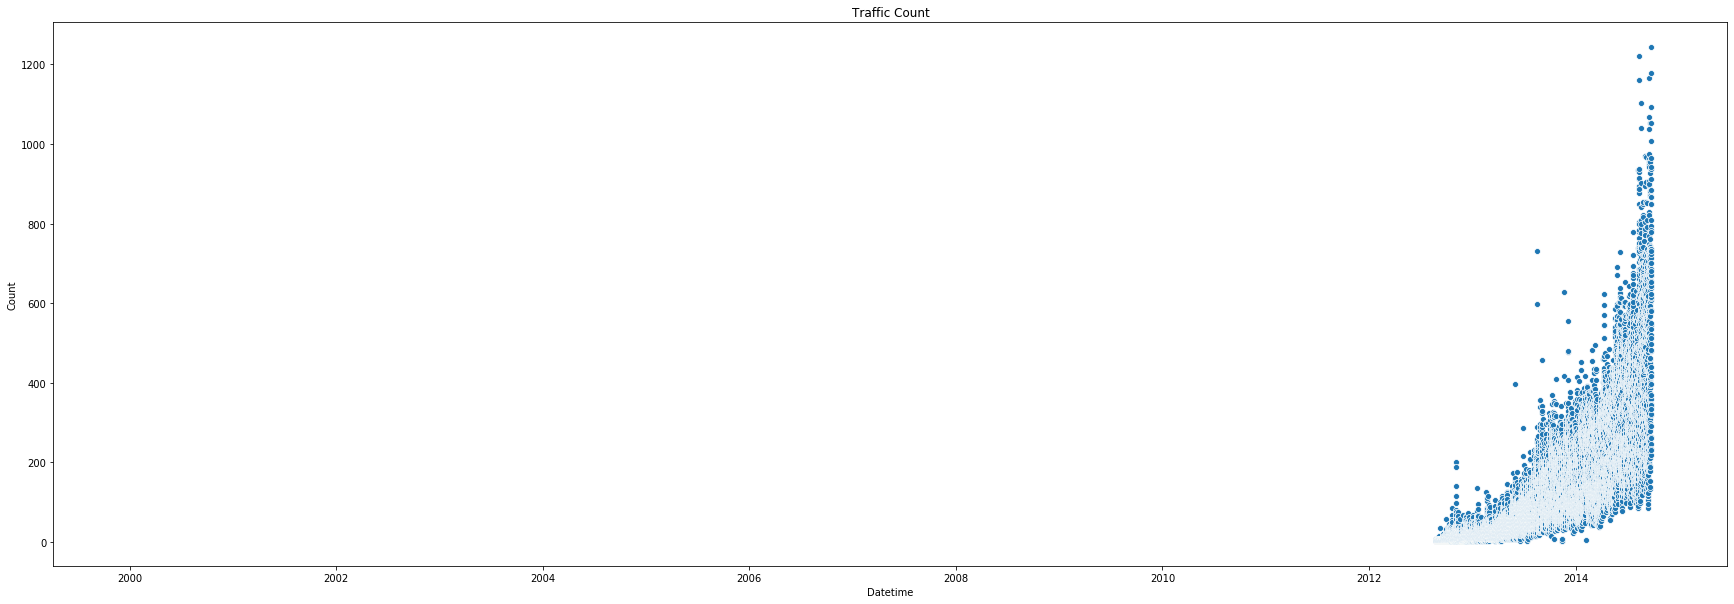

In [8]:
# Why is this one so scooted over??

plt.figure(figsize = (30, 10))
sns.scatterplot(x = data.Datetime, y = data.Count)
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

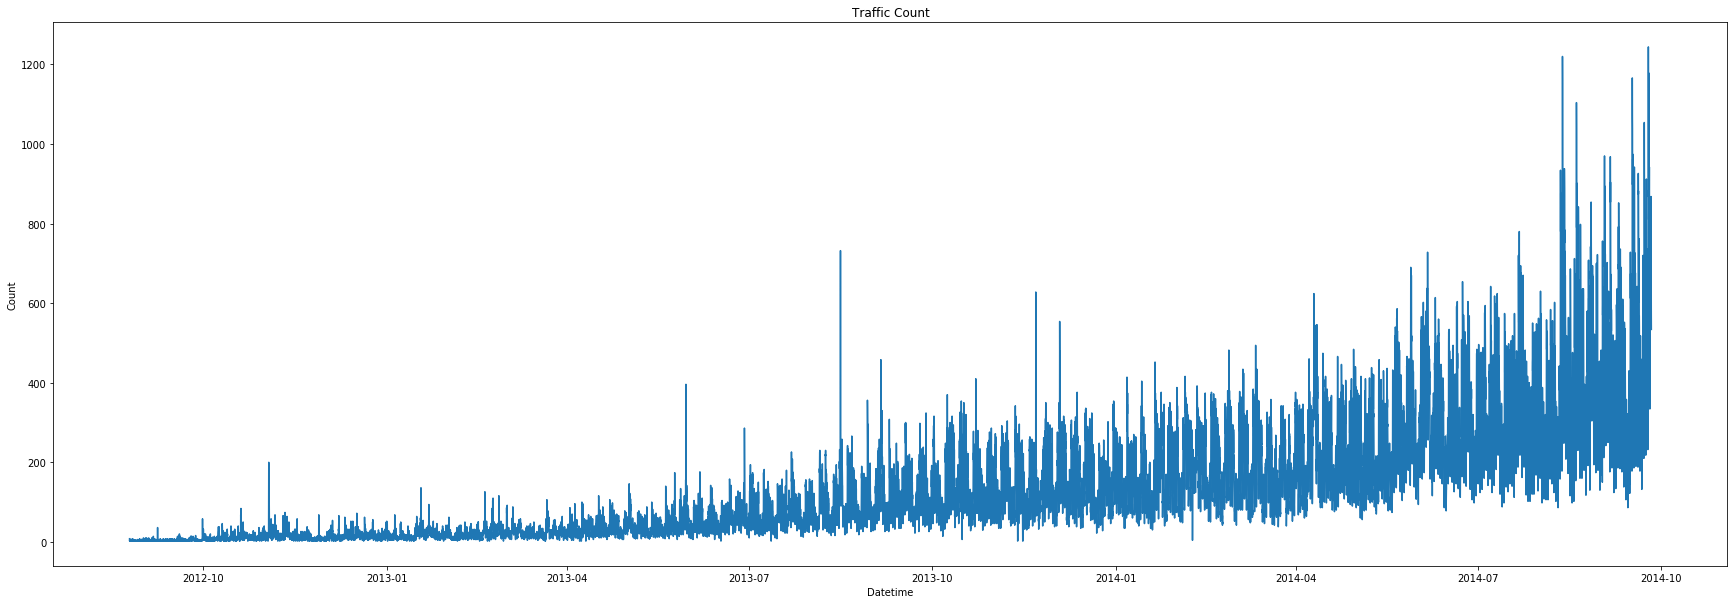

In [9]:
# Eh, don't like this one

plt.figure(figsize = (30, 10))
sns.lineplot(x = data.Datetime, y = data.Count)
plt.title(f'Traffic Count')
plt.autoscale()
plt.show()

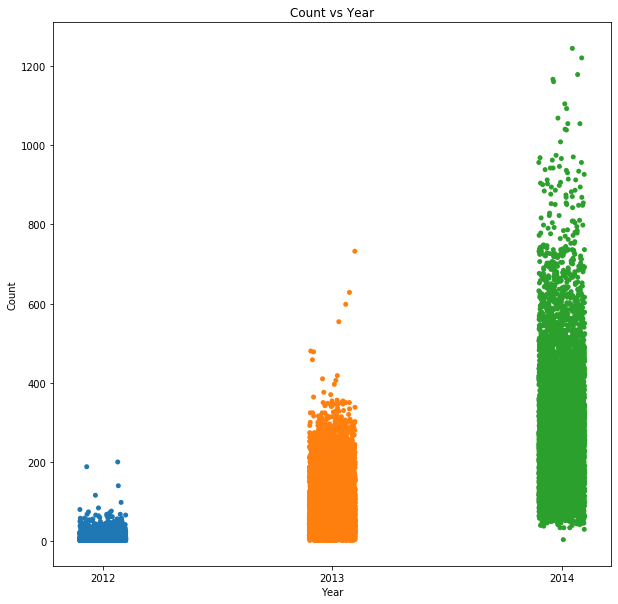

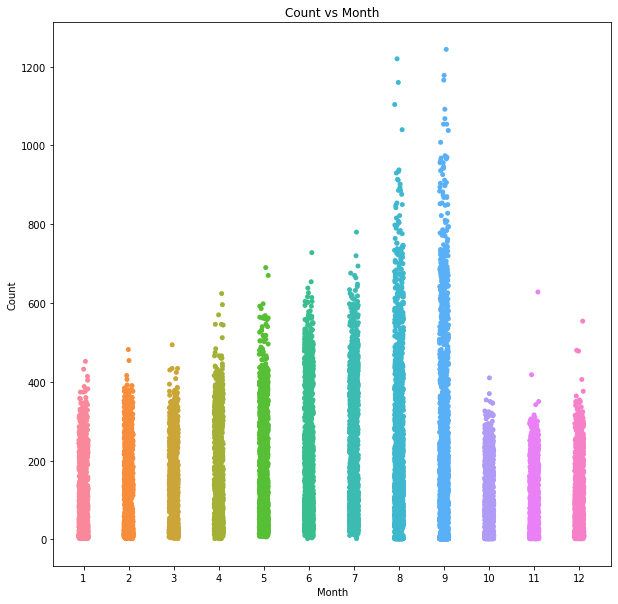

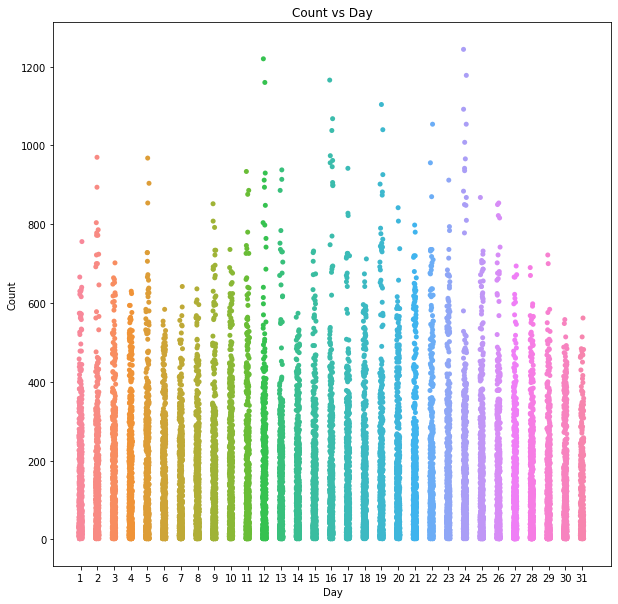

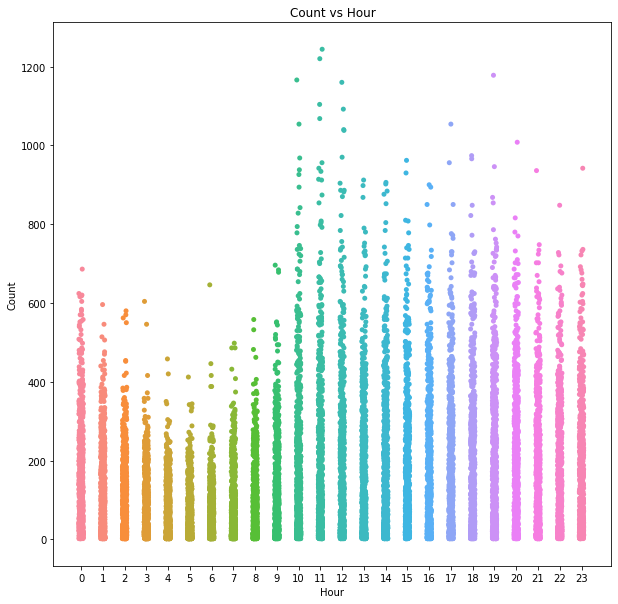

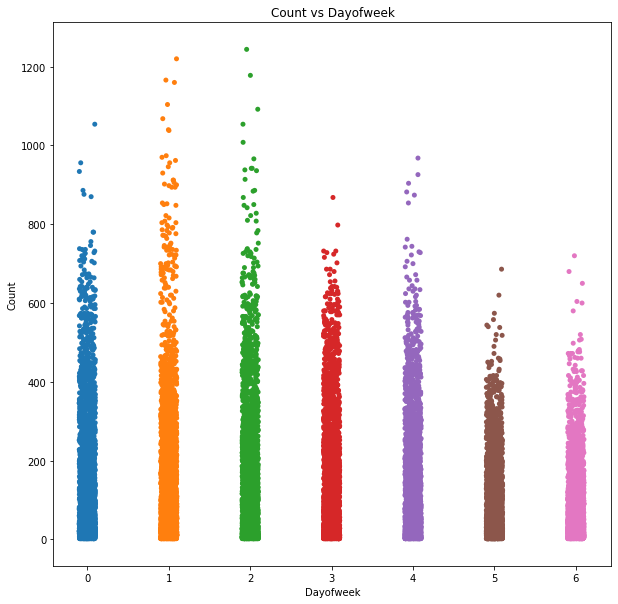

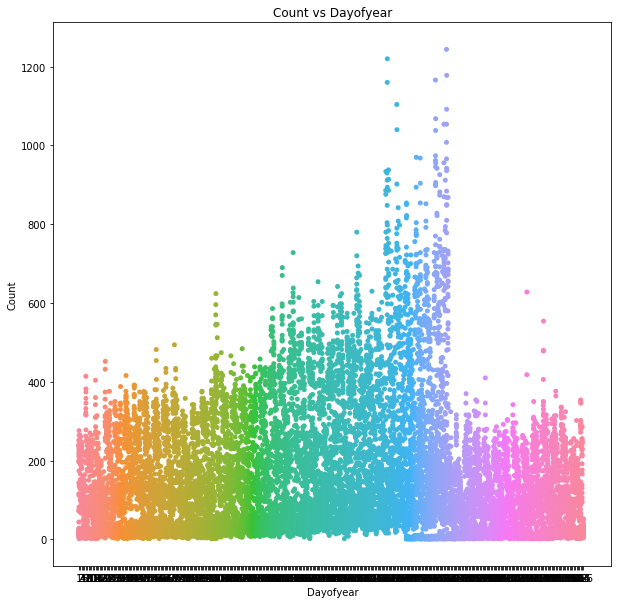

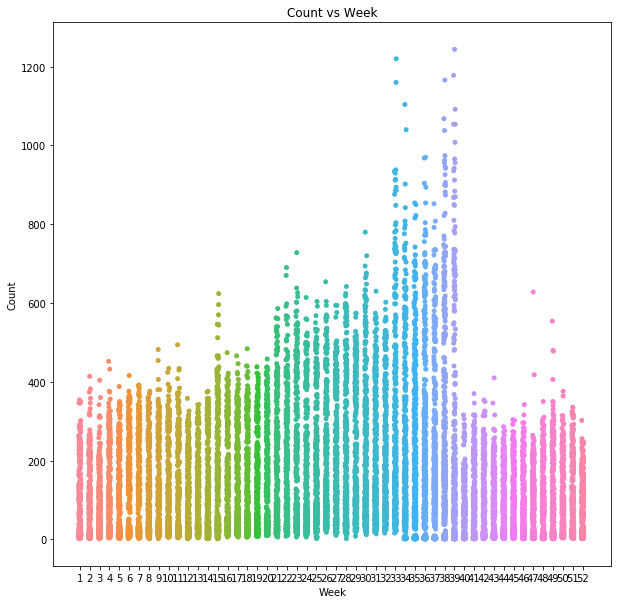

In [10]:
for feature in data.loc[:, 'Year':]:

    plt.figure(figsize = (10, 10))
    graph = sns.stripplot(x = feature, y = 'Count', hue = None, data = data)
    plt.title(f'Count vs {feature}')
    graph.autoscale()
    plt.show()

# Correlation

In [11]:
corr = data.corr()
display(corr)

,ID,Count,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
ID,1.000000,0.780628,0.914277,-1.252140e-01,3.519011e-03,1.311196e-03,-3.412345e-03,-1.278150e-01,-1.192923e-01
Count,0.780628,1.000000,0.674422,-1.580793e-03,-1.823101e-03,2.019169e-01,-1.667922e-01,-3.815246e-03,4.778247e-03
Year,0.914277,0.674422,1.000000,-5.149179e-01,-3.531297e-02,0.000000e+00,-2.646015e-03,-5.186236e-01,-5.014813e-01
Month,-0.125214,-0.001581,-0.514918,1.000000e+00,9.631257e-03,-5.438272e-18,-1.035835e-03,9.964115e-01,9.743542e-01
Day,0.003519,-0.001823,-0.035313,9.631257e-03,1.000000e+00,6.809503e-18,3.855013e-03,9.387427e-02,7.049420e-02
Hour,0.001311,0.201917,0.000000,-5.438272e-18,6.809503e-18,1.000000e+00,-9.817597e-20,-2.583756e-20,-6.059024e-18
Dayofweek,-0.003412,-0.166792,-0.002646,-1.035835e-03,3.855013e-03,-9.817597e-20,1.000000e+00,-7.164747e-04,-1.639304e-03
Dayofyear,-0.127815,-0.003815,-0.518624,9.964115e-01,9.387427e-02,-2.583756e-20,-7.164747e-04,1.000000e+00,9.760286e-01
Week,-0.119292,0.004778,-0.501481,9.743542e-01,7.049420e-02,-6.059024e-18,-1.639304e-03,9.760286e-01,1.000000e+00


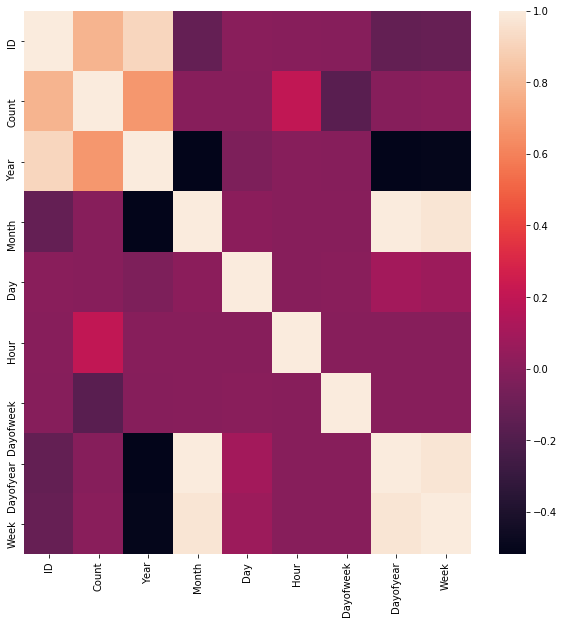

In [12]:
plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

<Figure size 720x720 with 0 Axes>

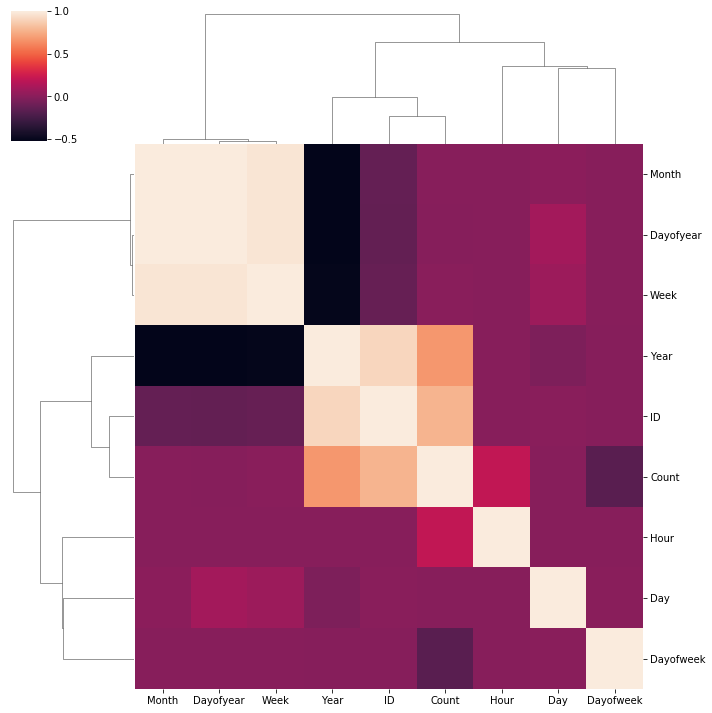

In [13]:
plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

# Model Training 1

Let's just dump everything into LightGBM and see what happens!

In [14]:
# Train Valid Split, I'll do k-fold later
# It's going to be important to keep leakage in mind, since this data is time based.
# Note, we don't need to split test data, as the competition has furnished us with test data.
# Why does it get so bad when I split the validation off from the end instead of randomly? Shouldn't that be good?

train, valid = train_test_split(data, shuffle = True, test_size = .2)

X_train = train.loc[:, 'Year':]
y_train = train.loc[:, 'Count']

X_valid = valid.loc[:, 'Year':]
y_valid = valid.loc[:, 'Count']

display(X_train)
display(X_valid)

,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
1410,2012,10,22,18,0,296,43
16310,2014,7,5,14,5,186,27
4453,2013,2,26,13,1,57,9
10319,2013,10,28,23,0,301,44
14543,2014,4,22,23,1,112,17
...,...,...,...,...,...,...,...
5846,2013,4,25,14,3,115,17
4815,2013,3,13,15,2,72,11
4405,2013,2,24,13,6,55,8
11889,2014,1,2,9,3,2,1


,Year,Month,Day,Hour,Dayofweek,Dayofyear,Week
6511,2013,5,23,7,3,143,21
16728,2014,7,23,0,2,204,30
16130,2014,6,28,2,5,179,26
17616,2014,8,29,0,4,241,35
15550,2014,6,3,22,1,154,23
...,...,...,...,...,...,...,...
15133,2014,5,17,13,5,137,20
12186,2014,1,14,18,1,14,3
13553,2014,3,12,17,2,71,11
7199,2013,6,20,23,3,171,25


In [15]:
model = lgb.LGBMRegressor(num_iterations = 5000)

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for the dump model is {error}')

'RMSE for the dump model is 27.593418714476332'

In [16]:
# Is this actually an acceptable way to calculate percent error? Better check that later.

mean = data.Count.mean()
percent_error = error / mean * 100

display(f'RMSE for the dump model is {error:.2f}')
display(f'Percent Error for the dump model is {percent_error:.2f}%')

'RMSE for the dump model is 27.59'

'Percent Error for the dump model is 19.86%'

Well, not terrible for a basic dump, but we could do a whole lot better I'm sure!!! About 21%

But, let's see how we're doing so far. Let's retrain on the whole data, and do a sample submission. Note that retraining on all the data means no early stopping rounds.

In [17]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(num_iterations = 2000)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit1.csv',index=False, header =1)

Nice! Got 138 on website

# Feature Importance

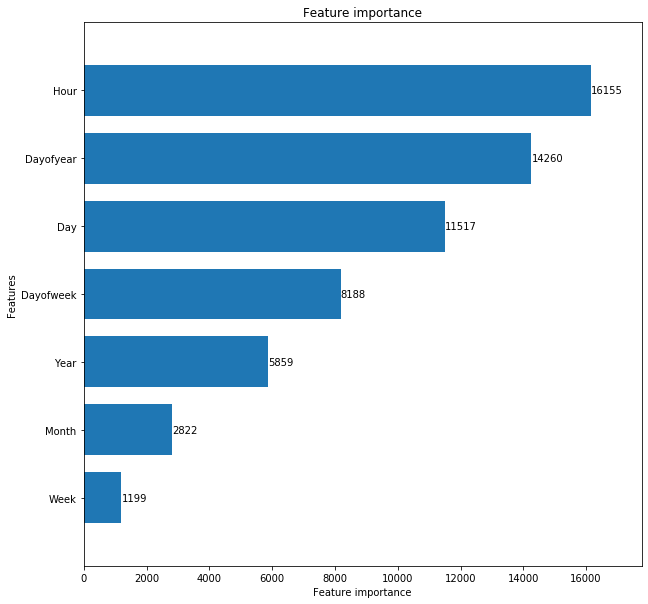

In [18]:
lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

# LightGBM Random Search

In [ ]:
# Here we'll use the whole training set, and cross validate with the random search cross validate function

X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

param_test = {
                'num_leaves': range(2, 20), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 1),
#                'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }


# Here we define the number of iterations for each of our random searches
num_iter = 10000


model = lgb.LGBMRegressor(silent=True, n_jobs=3, verbose = -1)


rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = num_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} NRMSE with params: {rs.best_params_} ')

X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = lgb.LGBMRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit2.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   28.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  7.8min


Let's keep track of some results as we tinker.

I believe this uses cross validation to score the random models. That's nice, we don't even have to do it ourselves!

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   18.3s finished  
Best score reached: -87.87970852411067 with params: {'num_leaves': 8, 'n_estimators': 400, 'learning_rate': 0.09}  
135 on the website

[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  3.6min finished  
Best score reached: -87.57504089628529 with params: {'num_leaves': 4, 'n_estimators': 4400, 'learning_rate': 0.04}  
142 on website

[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   46.1s finished  
Best score reached: -87.21698184675081 with params: {'num_leaves': 6, 'n_estimators': 300, 'learning_rate': 0.1}  
139 on website

[Parallel(n_jobs=2)]: Done 3600 out of 3600 | elapsed:  5.7min finished  
Best score reached: -87.21698184675081 with params: {'num_leaves': 6, 'n_estimators': 300, 'learning_rate': 0.1}  
139 on website

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed: 11.1min finished  
Best score reached: -87.31701171751358 with params: {'num_leaves': 6, 'n_estimators': 317, 'learning_rate': 0.1}  
139 on website

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed: 12.3min finished  
Best score reached: -87.2123427565559 RMSE with params: {'num_leaves': 6, 'n_estimators': 288, 'learning_rate': 0.1}  
139 on website

[Parallel(n_jobs=2)]: Done 5000 out of 5000 | elapsed: 10.8min finished  
Best score reached: -87.14251770327193 NRMSE with params: {'num_leaves': 6, 'n_estimators': 257, 'learning_rate': 0.1}  
139 on website

# XGBoost Random Search

Let's compare LightGBM to XGBoost

In [ ]:
X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

model = xgb.XGBRegressor(silent=True, n_jobs=3, verbose = False)

rs = rscv(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = num_iter,
            n_jobs = 2
            )

rs.fit(X_data, y_data, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

X_data = data.loc[:, 'Year':]
y_data = data.loc[:, 'Count']

X_test = test.loc[:, 'Year':]

model = xgb.XGBRegressor(**rs.best_params_)

model.fit(X_data, y_data, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'ID': test.ID, 'Count': predict})

output.to_csv(f'{filepath}submit3.csv',index=False, header =1)

plt.rcParams["figure.figsize"] = (10, 10)
xgb.plot_importance(model, height = .75, grid = False)
plt.show()

Let's keep track of some results as we tinker.

I believe this uses cross validation to score the random models.

[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.2min finished  
Best score reached: -89.66735403690507 with params: {'num_leaves': 8, 'n_estimators': 2700, 'learning_rate': 0.07}  
141 on website

[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 18.6min finished  
Best score reached: -89.3838475351944 with params: {'num_leaves': 3, 'n_estimators': 3100, 'learning_rate': 0.04}   
144 on website

[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  3.9min finished
Best score reached: -89.592554558878 with params: {'num_leaves': 5, 'n_estimators': 900, 'learning_rate': 0.09}  
148 on website, yeesh


# Comment

While it's interesting to submit various models to the website and compare their scores, this isn't a good idea for two reasons:
1. In general, it is bad practice to use test data (which in this case is the data from the website) to tune hyperparameters. That just causes your model to overfit the test data. The only purpose of test data is, once you've chosen what you believe to be the best model, to see how well that model generalizes.
2. For most, if not all, ML competitions, the score you see when you submit is on the public test data, which is only a fraction of the final private data. That means that, even if you get a high score on the public data, you may well do poorly when the final complete test data is used, as you will have overfit the public test data.

# Feature Generation 2

There are a number of other interesting timeseries data that we could generate, such as lag. However, I need to research more about how to use this data. It is easy to see how to generate it for the training data, but unclear how to generate it for the test data. We'd need to somehow predict each value, then generate the feature before predicting the next value, and so on.

This makes me think that there should be some better way of training, which looks at the data sequentially when building the model.

In [ ]:
# Let's generate some lag features.

# data['lag_1'] = data['Count'].shift(1)
# data['lag_2'] = data['Count'].shift(2)
# data['lag_3'] = data['Count'].shift(3)
# data['lag_4'] = data['Count'].shift(4)
# data['lag_5'] = data['Count'].shift(5)
# data['lag_6'] = data['Count'].shift(6)
# data['lag_7'] = data['Count'].shift(7)


# test['lag_1'] = test['Count'].shift(1)
# test['lag_2'] = test['Count'].shift(2)
# test['lag_3'] = test['Count'].shift(3)
# test['lag_4'] = test['Count'].shift(4)
# test['lag_5'] = test['Count'].shift(5)
# test['lag_6'] = test['Count'].shift(6)
# test['lag_7'] = test['Count'].shift(7)